     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 81.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 27.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 39.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 12.7 MB/s eta 0:00:00


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

sent_train.csv: 0.00B [00:00, ?B/s]

sent_valid.csv: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/9543 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2388 [00:00<?, ? examples/s]

Dataset cargado: zeroshot/twitter-financial-news-sentiment
DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 9543
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2388
    })
})
                                                text  label
0  $BYND - JPMorgan reels in expectations on Beyo...      0
1  $CCL $RCL - Nomura points to bookings weakness...      0
2  $CX - Cemex cut at Credit Suisse, J.P. Morgan ...      0
3  $ESS: BTIG Research cuts to Neutral https://t....      0
4  $FNKO - Funko slides after Piper Jaffray PT cu...      0
label
2    6178
1    1923
0    1442
Name: count, dtype: int64


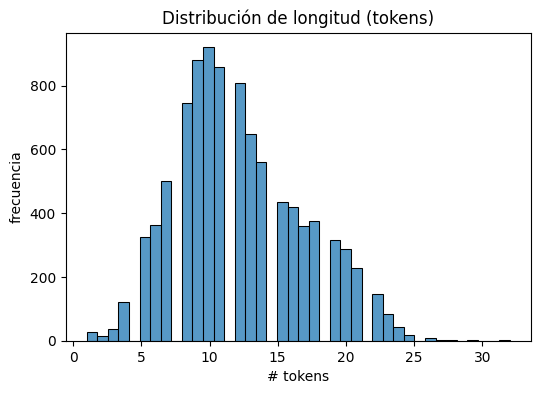

In [1]:
# Instalaciones (Colab)
!pip -q install -U transformers datasets evaluate scikit-learn matplotlib seaborn wordcloud accelerate gensim umap-learn

import os, random, json, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from datasets import load_dataset

SEED = 42
random.seed(SEED); np.random.seed(SEED)
torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)

# Carga del dataset financiero (EN)
def load_financial_news():
    ds = load_dataset("zeroshot/twitter-financial-news-sentiment")
    return ds, "zeroshot/twitter-financial-news-sentiment"

raw, source_name = load_financial_news()
print("Dataset cargado:", source_name)
print(raw)

# Normalizar a un DataFrame con columnas: text, label (0=Bearish, 1=Bullish, 2=Neutral)
def normalize_to_text_label(ds, source_name):
    split = "train" if "train" in ds else list(ds.keys())[0]
    df = ds[split].to_pandas()
    # heurísticas de nombre de columna de texto
    text_col_candidates = ["text", "tweet", "content", "sms", "sentence"]
    label_col_candidates = ["label", "labels", "target", "category"]

    text_col = next((c for c in text_col_candidates if c in df.columns), None)
    label_col = next((c for c in label_col_candidates if c in df.columns), None)

    if text_col is None:
        raise ValueError(f"No se encontró columna de texto en {df.columns.tolist()}")
    if label_col is None:
        raise ValueError(f"No se encontró columna de label en {df.columns.tolist()}")

    df = df[[text_col, label_col]].rename(columns={text_col: "text", label_col: "label"})

    # Labels ya son enteros 0/1/2 en este dataset; si fuesen strings, mapear
    if df["label"].dtype == object:
        # Mapear strings comunes
        mapping = {"bearish": 0, "bullish": 1, "neutral": 2}
        df["label"] = df["label"].map(lambda x: mapping.get(str(x).lower(), x))
    return df

df = normalize_to_text_label(raw, source_name)
df = df.dropna().reset_index(drop=True)

print(df.head())
print(df["label"].value_counts())

# Visualizaciones rápidas
df["length"] = df["text"].str.split().apply(len)
plt.figure(figsize=(6,4))
sns.histplot(df["length"], bins=40)
plt.title("Distribución de longitud (tokens)")
plt.xlabel("# tokens"); plt.ylabel("frecuencia")
plt.show()

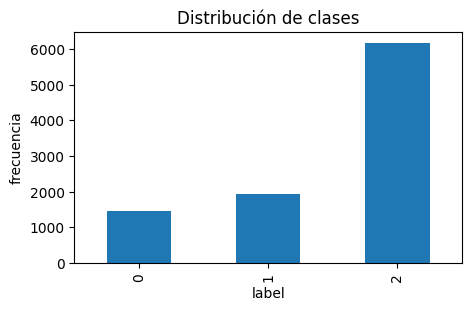


Top n-grams para clase 0:
co: 737
https: 735
https co: 735

Top n-grams para clase 1:
co: 852
https: 842
https co: 842

Top n-grams para clase 2:
co: 3559
https co: 3518
https: 3518


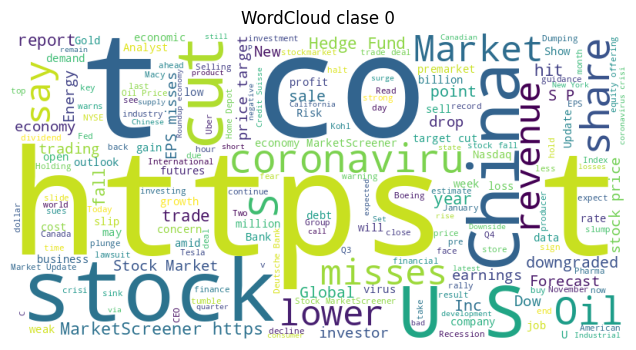

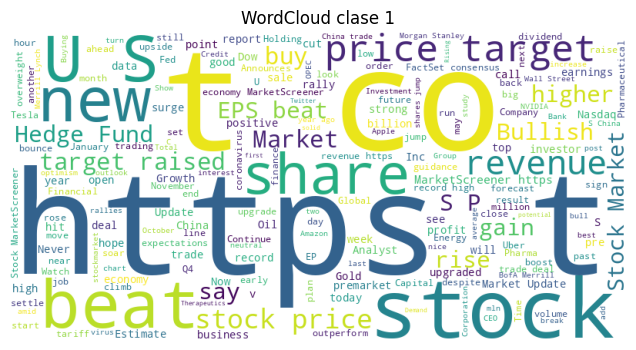

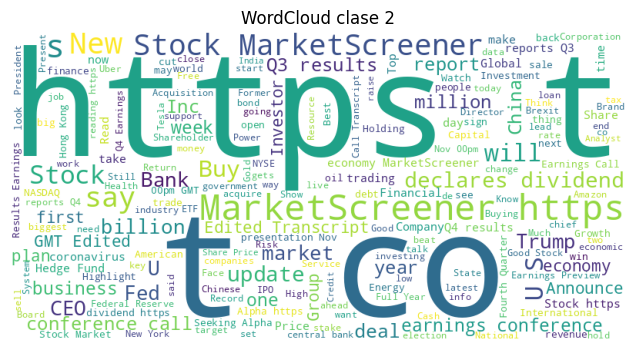

In [2]:
# EDA adicional: distribución de clases
plt.figure(figsize=(5,3))
df["label"].value_counts().sort_index().plot(kind="bar")
plt.title("Distribución de clases"); plt.xlabel("label"); plt.ylabel("frecuencia"); plt.show()

# Top n-grams por clase (BoW rápido)
from sklearn.feature_extraction.text import CountVectorizer
def top_ngrams_per_class(dataframe, label_col, text_col, ngram, topk):
    vec = CountVectorizer(max_features=100000, ngram_range=ngram)
    X = vec.fit_transform(dataframe[text_col])
    vocab = np.array(vec.get_feature_names_out())
    for label_value in sorted(dataframe[label_col].unique()):
        idx = (dataframe[label_col] == label_value).values
        counts = X[idx].sum(axis=0).A1
        top_idx = counts.argsort()[::-1][:topk]
        print(f"\nTop n-grams para clase {label_value}:")
        for token, c in zip(vocab[top_idx], counts[top_idx]):
            print(f"{token}: {c}")

top_ngrams_per_class(df, "label", "text", ngram=(1,2), topk=3)  # TODO: completar

# WordCloud por clase (si hay clases binarias/multiclase pequeñas)
from wordcloud import WordCloud
for label_value in sorted(df["label"].unique()):
    text_blob = " ".join(df.loc[df["label"] == label_value, "text"].astype(str).tolist())
    wc = WordCloud(width=800, height=400, background_color="white").generate(text_blob)
    plt.figure(figsize=(8,4)); plt.imshow(wc); plt.axis("off"); plt.title(f"WordCloud clase {label_value}"); plt.show()

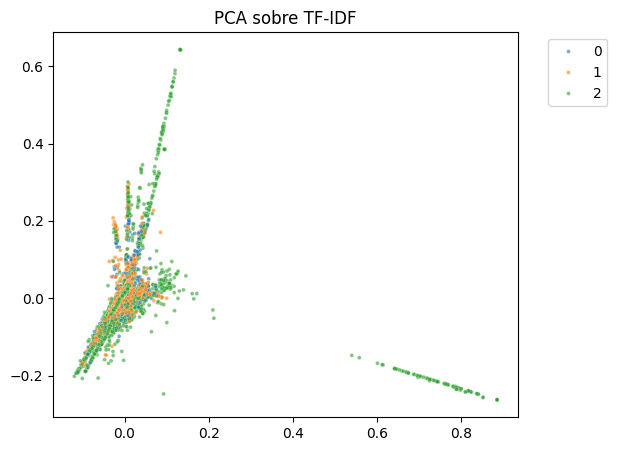

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


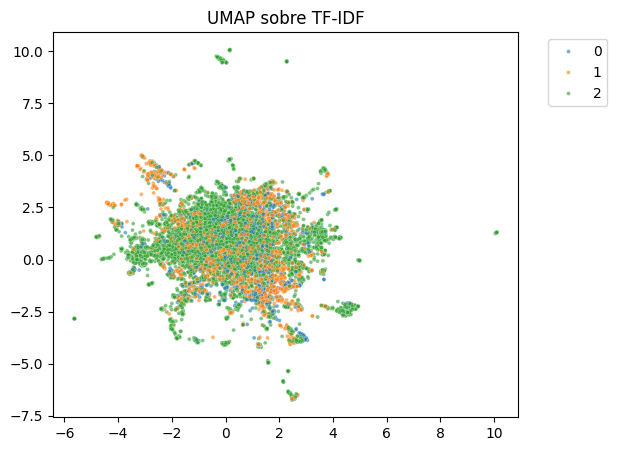


Vecinos de 'price':
[('cut', 0.9977649450302124), ('stock', 0.9968260526657104), ('raised', 0.9955847263336182), ('at', 0.9953780174255371), ('from', 0.9945676326751709), ('target', 0.9929817318916321), ('Deutsche', 0.9901884198188782), ('CFRA', 0.9891637563705444)]

Vecinos de 'target':
[('stock', 0.9942705631256104), ('price', 0.9929817914962769), ('cut', 0.9909344911575317), ('raised', 0.9867317080497742), ('at', 0.9860263466835022), ('from', 0.9845659732818604), ('Deutsche', 0.9789193272590637), ('CFRA', 0.9785357117652893)]

Vecinos de 'stock':
[('cut', 0.9978030323982239), ('price', 0.9968260526657104), ('raised', 0.9959227442741394), ('at', 0.995506763458252), ('from', 0.9947239756584167), ('target', 0.9942705631256104), ('Deutsche', 0.990071713924408), ('CFRA', 0.9894317984580994)]

Vecinos de 'market':
[('back', 0.9990159273147583), ('set', 0.9988171458244324), ('their', 0.998767614364624), ('make', 0.9987643957138062), ('but', 0.9987321496009827), ('stocks', 0.99870932102203

In [3]:
# Proyección TF-IDF con PCA/UMAP para ver separabilidad
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import umap

tfidf = TfidfVectorizer(max_features=30000, ngram_range=(1,2))
X = tfidf.fit_transform(df["text"])  # sparse

# PCA a 2D (aprox con truncated SVD si quisieras para sparse; aquí usamos .toarray() si cabe)
try:
    X_dense = X.toarray()
    pca = PCA(n_components=2, random_state=SEED)
    X_pca = pca.fit_transform(X_dense)
    plt.figure(figsize=(6,5))
    sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=df["label"], s=8, palette="tab10", alpha=0.6)
    plt.title("PCA sobre TF-IDF"); plt.legend(bbox_to_anchor=(1.05, 1), loc=2); plt.show()
except Exception:
    pass

# UMAP directamente desde sparse
reducer = umap.UMAP(n_components=2, random_state=SEED, metric="cosine")
X_umap = reducer.fit_transform(X)
plt.figure(figsize=(6,5))
sns.scatterplot(x=X_umap[:,0], y=X_umap[:,1], hue=df["label"], s=8, palette="tab10", alpha=0.6)
plt.title("UMAP sobre TF-IDF"); plt.legend(bbox_to_anchor=(1.05, 1), loc=2); plt.show()

# Word2Vec (exploratorio): vecinos más similares
from gensim.models import Word2Vec
sentences = [t.split() for t in df["text"].astype(str).tolist()]
w2v = Word2Vec(sentences, vector_size=100, window=5, min_count=5, workers=2, seed=SEED)
for probe in ["price", "target", "stock", "market"]:
    if probe in w2v.wv:
        print(f"\nVecinos de '{probe}':")
        print(w2v.wv.most_similar(probe, topn=8))

              precision    recall  f1-score   support

           0       0.83      0.39      0.53       288
           1       0.81      0.54      0.65       385
           2       0.79      0.97      0.87      1236

    accuracy                           0.80      1909
   macro avg       0.81      0.63      0.68      1909
weighted avg       0.80      0.80      0.78      1909



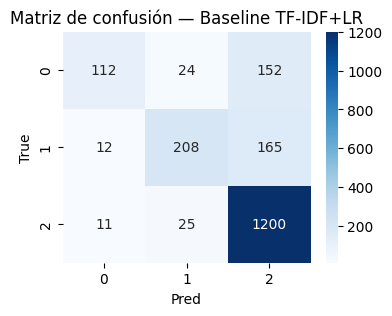

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(
    df["text"], df["label"], test_size=0.2, stratify=df["label"], random_state=42  # TODO: completar
)

vectorizer = TfidfVectorizer(max_features=30000, ngram_range=(1,2))  # TODO: completar
clf = LogisticRegression(max_iter=1000)  # TODO: completar

from sklearn.pipeline import Pipeline
pipe = Pipeline([
    ("tfidf", vectorizer),
    ("lr", clf)
])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de confusión — Baseline TF‑IDF+LR")
plt.xlabel("Pred"); plt.ylabel("True")
plt.show()

In [6]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset, DatasetDict, ClassLabel
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
import numpy as np

# Preparar splits desde pandas (estratificación robusta)
train_df, test_df = train_test_split(
    df[["text", "label"]], test_size=0.2, stratify=df["label"], random_state=SEED
)

train_ds = Dataset.from_pandas(train_df).rename_column("label", "labels")
test_ds = Dataset.from_pandas(test_df).rename_column("label", "labels")

# Asegurar ClassLabel binario cuando es posible
try:
    train_ds = train_ds.cast_column("labels", ClassLabel(num_classes=3))
    test_ds = test_ds.cast_column("labels", ClassLabel(num_classes=3))
except Exception:
    pass

splits = DatasetDict({"train": train_ds, "test": test_ds})

# Modelo en inglés orientado a finanzas; fallback a modelos genéricos
checkpoint_candidates = [
    "ProsusAI/finbert",                    # sugerido
    "SamLowe/roberta-base-go_emotions",                   # TODO: alternativa 1
    "distilbert/distilbert-base-uncased-finetuned-sst-2-english"                    # TODO: alternativa 2
]

def load_first_available_model(candidates):
    last_err = None
    for ck in candidates:
        try:
            tok = AutoTokenizer.from_pretrained(ck)
            mdl = AutoModelForSequenceClassification.from_pretrained(ck, num_labels=3)
            return ck, tok, mdl
        except Exception as e:
            last_err = e
    raise last_err

checkpoint, tokenizer, model = load_first_available_model(checkpoint_candidates)
print("Usando checkpoint:", checkpoint)

# Tokenización BPE: ejemplo rápido
samples = [
    "Esto es inaceptable y ofensivo.",
    "Gran trabajo del equipo, ¡excelente!"
]
for s in samples:
    toks = tokenizer.tokenize(s)
    print(f"\nTexto: {s}\nTokens: {toks}")

def tokenize(batch):
    return tokenizer(batch["text"], truncation=True, padding=True)

tokenized = splits.map(tokenize, batched=True)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=-1)
    unique = np.unique(labels)
    avg = "binary" if len(unique) == 2 else "macro"
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average=avg)
    }

args = TrainingArguments(
    output_dir="outputs",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=0.00005,                 # TODO
    per_device_train_batch_size=8,   # TODO
    per_device_eval_batch_size=8,    # TODO
    num_train_epochs=4,              # TODO
    weight_decay=0.01,                  # TODO
    logging_steps=2,
    load_best_model_at_end=True,
    metric_for_best_model="f1"
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized["train"],
    eval_dataset=tokenized["test"],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer
)

trainer.train()
results = trainer.evaluate()
print(results)

Casting the dataset:   0%|          | 0/7634 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/1909 [00:00<?, ? examples/s]

Usando checkpoint: ProsusAI/finbert

Texto: Esto es inaceptable y ofensivo.
Tokens: ['est', '##o', 'es', 'ina', '##ce', '##pta', '##ble', 'y', 'of', '##ens', '##ivo', '.']

Texto: Gran trabajo del equipo, ¡excelente!
Tokens: ['gran', 'tr', '##aba', '##jo', 'del', 'e', '##qui', '##po', ',', '¡', 'excel', '##ente', '!']


Map:   0%|          | 0/7634 [00:00<?, ? examples/s]

Map:   0%|          | 0/1909 [00:00<?, ? examples/s]

/tmp/ipython-input-4206513847.py:83: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: dsilveiracupre2014 (dsilveiracupre2014-universidad-catolica-del-uruguay) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.254100,0.445392,0.861184,0.816386
2,0.324600,0.520291,0.870613,0.830657
3,0.001800,0.604482,0.876375,0.834224
4,0.000500,0.688959,0.877423,0.838874


{'eval_loss': 0.6889590620994568, 'eval_accuracy': 0.8774227344159246, 'eval_f1': 0.8388742189325291, 'eval_runtime': 8.5961, 'eval_samples_per_second': 222.078, 'eval_steps_per_second': 27.803, 'epoch': 4.0}


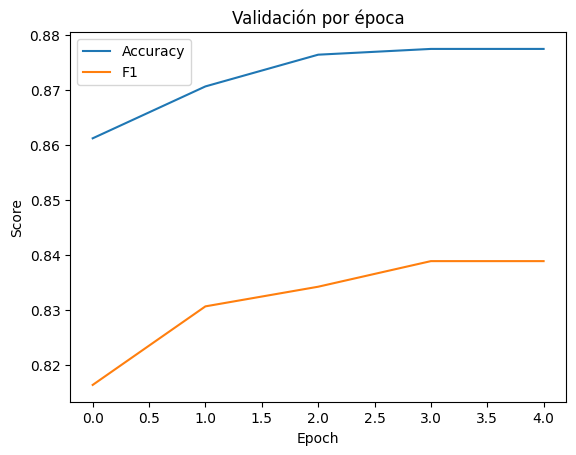

{'baseline': {'acc': 0.7962283918281823, 'f1': 0.6831007164673787}, 'transformer': {'acc': 0.8774227344159246, 'f1': 0.8388742189325291}}


In [7]:
# Curvas de métricas por época (si están en el state log)
hist = trainer.state.log_history
acc = [x['eval_accuracy'] for x in hist if 'eval_accuracy' in x]
f1s = [x['eval_f1'] for x in hist if 'eval_f1' in x]

plt.plot(acc, label="Accuracy")
plt.plot(f1s, label="F1")
plt.title("Validación por época")
plt.xlabel("Epoch"); plt.ylabel("Score"); plt.legend(); plt.show()

# Comparación simple Baseline vs Transformer
from sklearn.metrics import f1_score, accuracy_score
y_pred_base = pipe.predict(X_test)
base_acc = accuracy_score(y_test, y_pred_base)
base_f1 = f1_score(y_test, y_pred_base, average=("binary" if len(np.unique(y_test))==2 else "macro"))

preds_logits = trainer.predict(tokenized["test"]).predictions
y_pred_tr = preds_logits.argmax(axis=-1)
tr_acc = accuracy_score(tokenized["test"]["labels"], y_pred_tr)
tr_f1 = f1_score(tokenized["test"]["labels"], y_pred_tr, average=("binary" if len(np.unique(tokenized["test"]["labels"]))==2 else "macro"))

print({"baseline": {"acc": base_acc, "f1": base_f1}, "transformer": {"acc": tr_acc, "f1": tr_f1}})